# Create Torch image dataset

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import gc

In [10]:
import torch
from torchvision.transforms import ToTensor, Lambda, Compose, ConvertImageDtype, Normalize
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

In [25]:
from sklearn.model_selection import train_test_split

## Prepare labels dataset

In [14]:
links = pd.read_pickle('../../data/1_automarket_exploration/source_data/total_frame_valid_links_2020-01-23 11:07.pckl')
# leav only valid images
labels = links[links['valid_img_count'] != 0]\
        [['producer', 'case', 'price', 'total_img_count']].reset_index()\
                                                          .rename(columns={'index':'dir_num'})
# code category properties
dicts = {}
for col in ['producer', 'case']:
    labels[col]  = labels[col].astype('category')
    labels[f'{col}_code'] = labels[col].cat.codes
    dicts[col] = dict(zip(labels[col].cat.codes, labels[col]))

#create path to image    
labels['path'] = [f'img/{idx}/0.webp' for idx in labels['dir_num']]


## Check shapes and clean image datatset

In [17]:
%%time
shapes = {}
errors = []
for idx, row in labels[['dir_num','path']].iterrows():
    try:
        img = Image.open(os.path.join('../../data/1_automarket_exploration/auto_img/', row['path']))
        shapes[row['dir_num']] = np.array(img).shape
        
    except Exception as e:
        errors.append(row['dir_num'])
        print(row['dir_num'], e)

3664 cannot identify image file '../../data/1_automarket_exploration/auto_img/img/3664/0.webp'
CPU times: user 6min 18s, sys: 15.5 s, total: 6min 34s
Wall time: 11min 44s


### Exclude images with other shapese

In [18]:
labels['shape'] = labels['dir_num'].map(shapes)

In [21]:
labels = labels[~labels['dir_num'].isin(errors)]
labels =  labels[labels['shape'] == (240, 320, 3)]

### Split on train and test datasets.

In [26]:
train, test = train_test_split(labels['dir_num'], random_state=42, test_size=0.2)
labels.loc[labels['dir_num'].isin(train), 'train'] = 'train'
labels.loc[labels['dir_num'].isin(test), 'train'] = 'test'

### Save annotations frame

In [27]:
labels.to_pickle('../../data/1_automarket_exploration/source_data/labels.pckl')

In [28]:
labels = pd.read_pickle('../../data/1_automarket_exploration/source_data/labels.pckl')

## Create custom dataset class

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations, img_dir, target, path, 
                 train=True, transform=None, target_transform=None, task='class'):
        if train:
            flag = 'train'
        else:
            flag = 'test'
        data = pd.read_pickle(annotations).query('train == @flag')
        self.img_paths = list(data[path])
        self.img_labels = list(data[target])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.class_labels = None
        if task == 'class':
            self.class_labels = dict(zip(data[target], data['producer']))
        
    def __len__(self):
        return len(self.img_labels)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = read_image(img_path)
        label = self.img_labels[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label
    
    def get_class_labels(self):
        return self.class_labels

## Create instance and make dataloader

In [21]:
transf = Compose([ConvertImageDtype(torch.float),
                  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                 ])

In [22]:
train = CustomImageDataset('../../data/1_automarket_exploration/source_data/labels.pckl',
                           '../../data/1_automarket_exploration/auto_img/',
                           'producer_code',
                           'path',
                           train=True,
                           transform = transf,
                           target_transform = Lambda(lambda y: torch.zeros(
                               12, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
                           )
train_dataloader = DataLoader(train, batch_size=4, shuffle=True)

In [23]:
test = CustomImageDataset('../../data/1_automarket_exploration/source_data/labels.pckl',
                           '../../data/1_automarket_exploration/auto_img/',
                           'producer_code',
                           'path',
                           train=False,
                           transform = transf,
                           target_transform = Lambda(lambda y: torch.zeros(
                               12, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
                           )
test_dataloader = DataLoader(test, batch_size=4, shuffle=True)

In [34]:
def imshow(img):
    plt.figure(figsize=(16,4))
    img = img / 2 + 0.5
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.show()

## Check that all work correctly

***Train dataset***

Feature batch shape: torch.Size([4, 3, 240, 320])
Labels batch shape: torch.Size([4, 12])


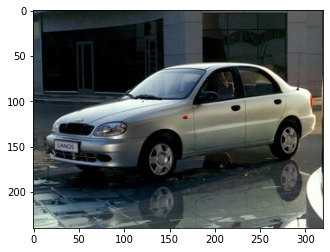

In [30]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0] / 2 + 0.5
img = img.permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
#plt.title(dicts['producer'][int(label.argmax())])
plt.show()

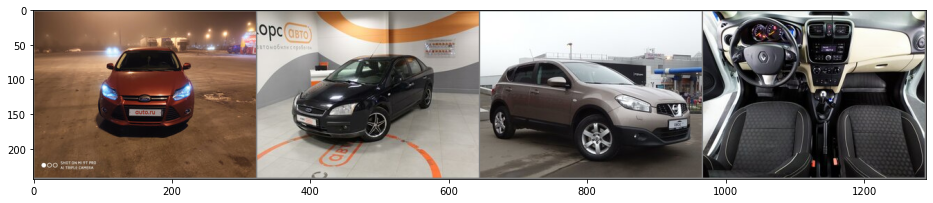

In [35]:
train_features, train_labels = next(iter(train_dataloader))
imshow(make_grid(train_features))

***Test dataset***

Feature batch shape: torch.Size([4, 3, 240, 320])
Labels batch shape: torch.Size([4, 12])


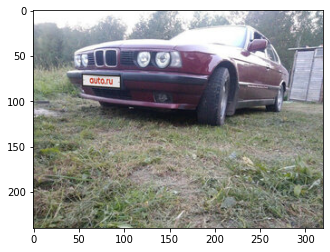

In [31]:
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0] / 2 + 0.5
img = img.permute(1, 2, 0)
label = test_labels[0]
plt.imshow(img)
#plt.title(dicts['producer'][int(label.argmax())])
plt.show()